In [1]:
# Code to import standard libraries

import sys
sys.path.append("../lib") # go to parent dir

import numpy as np
import scipy
import pandas as pd

import income.distributions as distributions
import income.utils as utils
import income.surveys as surveys

%matplotlib inline
from IPython.display import HTML

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)
colors = ['r','g','b']

# Fitting distributions to grouped data

The emphasis is on density functions, because a well-estimated density will usually result in good transformations (e.g. c.d.f, lorenz curve), whereas the reverse is often not true.

## Common issues with Lorenz curve data

In practice, empirical Lorenz curve data derived from consumption or income surveys suffer from a number of issues that the theoretical treatment may ignore.

### Negative and zero values

In consumption surveys, it is impossible - by construction - for a person to have negative consumption, and effectively impossible to have zero consumption (given minimum caloric requirements, etc.). In income surveys this is not the case, and many of the surveys including in PovCalNet indicate the presence of negative or zero incomes, in one of two ways:

- The Lorenz curve may be non-increasing. The theoretial condition that a Lorenz curve must be increasing and convex holds only for an income distribution which is non-negative and has no atoms. Negative incomes result in a curve which is decreasing initially, while atoms of probability (for instance at zero) result in sections which are flat. It is often the case, for example, that the first several $L(p)$ values are zero, which indicates that some non-zero proportion of the sample have zero incomes. In some cases, grouping may hide negative incomes (if the first group is a mix of negative and positive incomes), but the best fit will strongly suggest that negative incomes were present.
- More simply, the sample minimum may be reported as negative

> At present we do not attempt to deal well with negative or zero incomes. These usually represent around 1% of the sample, so we simply discard them and renormalize the distribution accordingly.

#### Example

Below, we show an example of data from PovCalNet with zero incomes (Venezuela, 2005 - apparently around 8% of the sample is zero, which is an extreme case). A pecularity of PovCalNet means that points are repeated in this scenario.

In [2]:
# Code to output the first 10 points of the Venezuela, 2005 lorenz table

survey = surveys.PovcalSurvey('../data/jsoncache/VEN_3_2005.json')
print("Survey minimum ($PPP/month)", survey.min_ppp_month)
pd.DataFrame(list(zip(survey.lorenz_points_p, survey.lorenz_points_L)), columns=["$p$", "$L(p)$"])[:10]

Survey minimum ($PPP/month) 0.0


,$p$,$L(p)$
0,0.000000,0.000000
1,0.083534,0.000000
2,0.083534,0.000000
3,0.083534,0.000000
4,0.083534,0.000000
5,0.083534,0.000000
6,0.083534,0.000000
7,0.083534,0.000000
8,0.083534,0.000000
9,0.090028,0.000113


And also, an example of data with negative incomes (Denmark, 2012 - only the decreasing portion of the curve represents negative incomes, so here, less than 2%).

In [3]:
# Code to output the first 10 points of the Denmark, 2012 lorenz table

survey = surveys.PovcalSurvey('../data/jsoncache/DNK_3_2012.json')
print("Survey minimum ($PPP/month)", survey.min_ppp_month)
pd.DataFrame(list(zip(survey.lorenz_points_p, survey.lorenz_points_L)), columns=["$p$", "$L(p)$"])[:5]

Survey minimum ($PPP/month) -8251.09


,$p$,$L(p)$
0,0.000000,0.000000
1,0.010533,-0.004321
2,0.020433,-0.003299
3,0.030760,-0.000712
4,0.040859,0.002762


### Tails, minimums & maximums

### Smoothing

We can consider two dimensions to smoothing, one statistical and one aesthetic.

In the statistical (inferential) sense, smoothing is a trade-off between bias and variance, which arises because we are dealing with a sample rather than a complete population. If we fit a Lorenz curve that passes precisely through each point in the grouped data, we are likely to overfit to sampling noise - increasing the variance of the modelled distribution, resulting in artefacts. On the other hand, smoothing will regularize the distribution towards some restricted class of distributions, but this will inevitably bias the estimated distribution. In this frame, parametric distributions (say, a two-parameter lognormal) are just an extreme form of smoothing, extremely robust to sampling error but forcing the distribution into a form that is unlikely to be 'true'. Intuitively, more smoothing will be needed when the number of Lorenz points is high relative to the sample size (i.e. $P/N$ is high), since this reduces the effective group size.

In an aesthetic sense, smoothing is important in emphasising salient aspects of the data. This is not a sampling issue, but a question of how best to communicate the population distribution. In reality, population income distributions are unlikely to share the properties of commonly used distributions like the lognormal or Pareto. They may exhibit clustering or spikes before certain thresholds (for example, \$25,000 may be a much more common salary than \$24,999, resulting in a spike). A true rendering of the distribution would reflect these features, but -- depending on the visualization -- a viewer may find them distracting, prefering to see the overall shape of the distribution. In particular, if a series of distributions is being compared over time, and these "systemic artefacts" move around (e.g because of currency conversion, or perhaps because thresholds themselves move), that can make it harder to understand the main changes.

(Another way of thinking of this is that even a population dataset is a random 'draw' from a hypothetical true, unknowable distribution, and that it is this distribution we would like to model. This would also argue for smoothing even of population data.)

> Ideally these dimensions would be separated
>
> 1. statistical smoothing would be handled during the fitting of the grouped data, to minimize some criterion (e.g. mean-square error)
> 2. aesthetic smoothing would be handled during visualization, dependent on the visualization
>
> In practice we smooth once at the time of fitting. Some vizualisations (e.g. histograms) naturally impose an additional smoothing step (through bin size), but we are not rigorous about this.

#### Example

To understand the smoothing issue, it can help to see different degrees of smoothing. We first simulate a population of 1000 incomes from a lognormal distribution, then take a sample of 200, which we aggregate into 20 groups. The resulting Lorenz curve is plotted below.

In [4]:
# Code to generate a population and sample from a lognormal distribution

N_population = 1000
N = 200
N_groups = 20

# Create the generating distribution, and generate a population then take a sample
dist = distributions.LognormalIncomeDistribution(mean = 100, Gini=0.3)
population = dist.generate(N_population)
sample = np.random.choice(population, N)

# Construct the lorenz curve for the groups
split_indices = (np.linspace(0, 1, N_groups+1)[1:-1] * N + 0.5).astype(int)
sample.sort()
groups = np.split(sample, split_indices)

p = np.array([0.0] + [len(g) / len(sample) for g in groups]).cumsum()
L = np.array([0.0] + [sum(g) / sum(sample) for g in groups]).cumsum()
sample_mean = sample.mean()

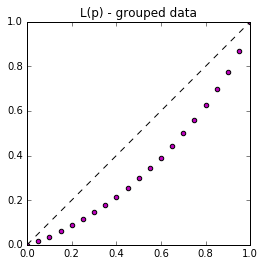

In [5]:
# Code to plot lorenz curves for the grouped data
plt.rcParams["figure.figsize"] = (4,4)

x = np.linspace(0, 1, 100)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(p, L, c="m")

# Plot the 45 degree line (total equality)
plt.plot(x,x,"k--")

plt.title("L(p) - grouped data");

We then fit the Lorenz curve using a simple quintic spline (see below for explanation). Below, we show the c.d.f and p.d.f for (left to right):

1. The distribution inferred from the grouped data (no smoothing)
2. The distribution inferred from the grouped data (smoothing)
3. The (discrete) sample distribution from unit records
4. The (discrete) population distribution
5. The hypothetical/generating population distribution (ie. lognormal)

For 3 and 4 we show normalized histograms rather than the p.d.f (which does not exist) or the p.m.f. (which has too many points to be easily visualized ungrouped).

In [6]:
# Unsmoothed
lorenz_unsmooth = scipy.interpolate.UnivariateSpline(p, L, k=5, s = 0)
quantile_unsmooth = lambda p: sample_mean * utils.derivative(lorenz_unsmooth)(p)
cdf_unsmooth = utils.inverse(quantile_unsmooth)
pdf_unsmooth = utils.derivative(cdf_unsmooth)

# Smoothed
lorenz_smooth = scipy.interpolate.UnivariateSpline(p, L, k=5, s = 0.0001)
quantile_smooth = lambda p: sample_mean * utils.derivative(lorenz_smooth)(p)
cdf_smooth = utils.inverse(quantile_smooth)
pdf_smooth = utils.derivative(cdf_smooth)

# Full sample
dist_sample = scipy.stats.rv_discrete(name='Sample (N=100)', values=(sample, [1/N]*N))
cdf_sample = dist_sample.cdf
pmf_sample = dist_sample.pmf

# Full population
dist_pop = scipy.stats.rv_discrete(name='Population (N_pop=1000)', values=(population, [1/N_population]*N_population))
cdf_pop = dist_pop.cdf
pmf_pop = dist_pop.pmf


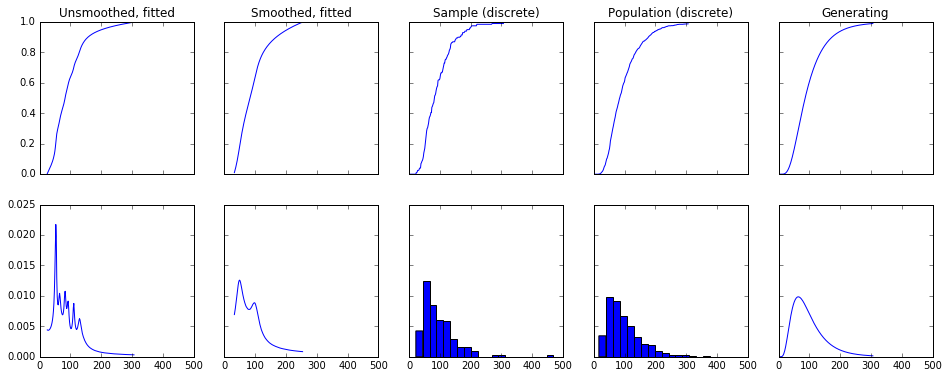

In [7]:
##########################################
plt.rcParams["figure.figsize"] = (16,6)
fig, ax = plt.subplots(2, 5, sharex='all', sharey='row')
##########################################

y = np.linspace(0, dist.quantile(0.99), 200)

ax[0, 0].set_title("Unsmoothed, fitted")
ax[0, 0].plot(y, cdf_unsmooth(y))
ax[1, 0].plot(y, pdf_unsmooth(y))

ax[0, 1].set_title("Smoothed, fitted")
ax[0, 1].plot(y, cdf_smooth(y))
ax[1, 1].plot(y, pdf_smooth(y))

ax[0, 2].set_title("Sample (discrete)")
ax[0, 2].plot(y, cdf_sample(y))
ax[1, 2].hist(sample, bins=20, normed=True)

ax[0, 3].set_title("Population (discrete)")
ax[0, 3].plot(y, cdf_pop(y))
ax[1, 3].hist(population, bins=20, normed=True)

ax[0, 4].set_title("Generating")
ax[0, 4].plot(y, dist.cdf(y))
ax[1, 4].plot(y, dist.pdf(y))

We can see easily that the unsmoothed fitted distribution, while faithful to the sample (compare the c.d.f.s), is overfitted, and results in a p.d.f which includes sampling artefacts. With smoothing, the fitted distribution is both closer to the population and generating distribution, and has a p.d.f which is much easier to interpret.

That said, the smoothed, fitted distribution still has some issues: it is too "peaky", and misses the left tail (which has not been captured in the sample). Issues like this lead us not to prefer the simple spline-interpolated Lorenz curve, although we consider it further below.

## Fitting methods

Fitting income distributions from grouped data is a well-established problem, and many different approaches exist. We experimented with many of these, and will briefly survey them before describing the approach eventually taken.

In the survey, we demonstrate many of the methods on real data for four PovCalNet surveys:

In [8]:
# Code to load up the surveys that will serve as examples in this section
demos = [
    surveys.PovcalSurvey('../../jsoncache/BRA_3_2014.json'),
    surveys.PovcalSurvey('../../jsoncache/MOZ_3_2008.67.json'),
    surveys.PovcalSurvey('../../jsoncache/IDN_1_2014.json'),
    surveys.PovcalSurvey('../../jsoncache/CHN_2_2013.json'),    
]


pd.DataFrame([(survey.country, survey.year, survey.coverage, survey.format) for survey in demos],
             columns=("Country", "Year", "Coverage", "Format"))

,Country,Year,Coverage,Format
0,Brazil,2014,National,Unit record
1,Mozambique,2008,National,Unit record
2,Indonesia,2014,Rural,Unit record
3,China,2013,Urban,Grouped


### Parametric

Parametric distributions often fit income data quite well, and easy to work with. They are used both in the academic literature (e.g. Lakner & Milanovic, 2013) and in other web visualizations (e.g. Gapminder, described above).

Parametric distributions are also used implicitly in PovCalNet itself, when unit record data are unavailable. In these cases, both a "general quadratic lorenz curve" and a "beta lorenz curve" are fit to the Lorenz points, with the superior fit being used to generate statistics.

#### Lognormal

The lognormal distribution (introduced in Chapter 2) is perhaps the easiest to fit from Lorenz curve data. It has two parameters, usually given as the mean $\mu$ and variance $\sigma^2$ of the normal distribution of log income. However, $\sigma^2$ can be calculated directly to the Gini index of the distribution, and $\mu$ can calculated from the mean of income. So from an estimate of the Gini index ($\hat G$) and of the mean ($\bar Y$), it is trivial to fit the distribution as follows:

$$
    \sigma = \sqrt{2} \Phi^{-1}\left(\frac{\hat G + 1}{2}\right) \\
    \mu = \log(\bar Y) - \frac{\sigma^2}{2}
$$

The four example surveys have the following lognormal fits. Note that all the distributions have essentially the same shape, which is imposed by the parametric form. The income axis scaling is set so that the 99th percentile is at the right.

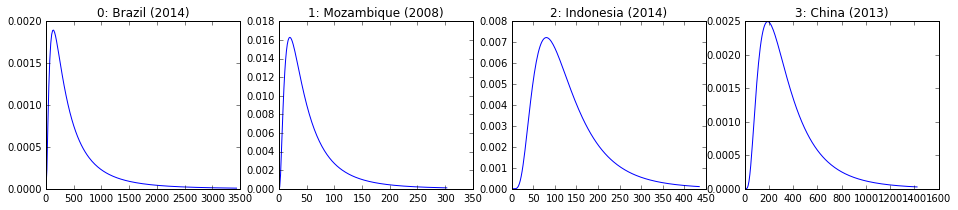

In [9]:
# Code to fit lognormal distributions and plot the density for each example

##########################################
plt.rcParams["figure.figsize"] = (16,3)
fig, axs = plt.subplots(1, 4)
##########################################

refdists = []

for i, (survey, ax) in enumerate(zip(demos, axs)):
    dist = distributions.LognormalIncomeDistribution.from_lorenz(
        survey.mean_ppp_month,
        survey.lorenz_points_p,
        survey.lorenz_points_L
    )
    refdists.append(dist)
    
    y = np.linspace(0, dist.quantile(0.99), 200)
    ax.plot(y, dist.pdf(y))
    ax.set_title("{}: {} ({})".format(i, survey.country, survey.year))

#### General Quadratic

The general quadratic method was introduced by ([Villasenor & Arnold, 1989](http://www.sciencedirect.com/science/article/pii/0304407689900894)) for the specific purpose of fitting Lorenz curves. We will not the describe the details here, only note the method of fitting, which is by linear regression of the following equation in $L$ and $p$ of the Lorenz curve.

$$
L(1-L) = a(p^2 - L) + bL(p-1) + c(p-L)
$$

A feature of the general quadratic Lorenz is that it implies a potentially non-zero lower bound and finite upper bound for the distribution, given by:

stuff

The density function is then:

more stuff

where K is a constant required so that the density integrates to 1 (between the lower and upper bounds), and which is calculated numerically.

The four example surveys have the following general quadratic fits. The general shape is quite similar to the lognormal, but the non-zero lower bound potentially implies quite different results in the left tail.

../lib/income/distributions.py:338: RuntimeWarning: divide by zero encountered in true_divide
  return (1 + ((x - self.nu)/self.tau)**2)**(-3/2) / self.L1_normaliser * (x >= self.lower) * (x <= self.upper)
../lib/income/distributions.py:338: RuntimeWarning: invalid value encountered in multiply
  return (1 + ((x - self.nu)/self.tau)**2)**(-3/2) / self.L1_normaliser * (x >= self.lower) * (x <= self.upper)


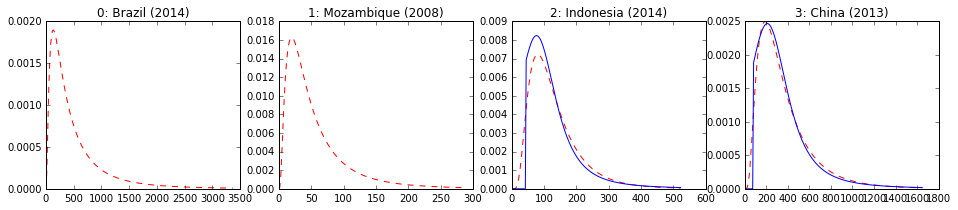

In [10]:
# Code to fit general quadratic distributions and plot the density for each example

##########################################
plt.rcParams["figure.figsize"] = (16,3)
fig, axs = plt.subplots(1, 4)
##########################################

for i, (survey, ax, refdist) in enumerate(zip(demos, axs, refdists)):
    dist = distributions.GeneralQuadraticIncomeDistribution.from_lorenz(
        survey.mean_ppp_month,
        survey.lorenz_points_p,
        survey.lorenz_points_L
    )
    
    y = np.linspace(0, dist.quantile(0.99), 200)
    ax.plot(y, refdist.pdf(y), "r--")
    ax.plot(y, dist.pdf(y))
    ax.set_title("{}: {} ({})".format(i, survey.country, survey.year))

#### Beta Lorenz

../lib/income/distributions.py:360: RuntimeWarning: invalid value encountered in double_scalars
  return p - self.theta * p ** self.gamma * (1 - p) ** self.delta


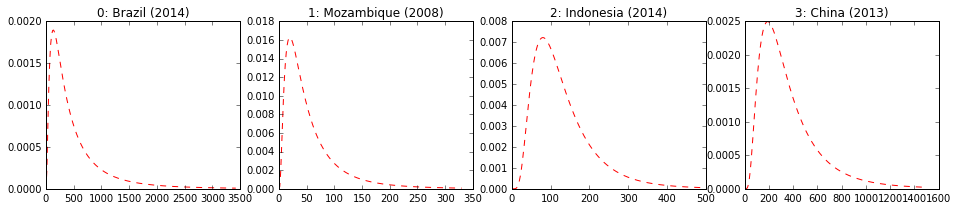

In [11]:
# Code to fit beta lorenz distributions and plot the density for each example

##########################################
plt.rcParams["figure.figsize"] = (16,3)
fig, axs = plt.subplots(1, 4)
##########################################

for i, (survey, ax, refdist) in enumerate(zip(demos, axs, refdists)):
    dist = distributions.BetaLorenzIncomeDistribution.from_lorenz(
        survey.mean_ppp_month,
        survey.lorenz_points_p,
        survey.lorenz_points_L
    )
    
    y = np.linspace(0, dist.quantile(0.99), 200)
    ax.plot(y, refdist.pdf(y), "r--")
    ax.plot(y, dist.pdf(y))
    ax.set_title("{}: {} ({})".format(i, survey.country, survey.year))

#### Post-adjustment

[Shorrocks & Wan (2008)](https://www.wider.unu.edu/publication/ungrouping-income-distributions) suggest a procedure for fitting a distribution to a grouped income data, by adjusting the output from a parametric fit (e.g. lognormal). Since the procedure creates a synthetic sample, rather than a distributional form (e.g. a p.d.f. or c.d.f), we did not closely consider it for this project. It is, however, worth noting (a) because it could be combined with another method (e.g. kernel density estimation) to estimate a distribution (this is especially true if a large sample is generated and (b) it is implemented in the Stata `ungroup` command of the popular [DASP package](http://dasp.ecn.ulaval.ca/modules/DASP_V2.3/DASP_MANUAL_V2.3.pdf) and hence is quite widely used (e.g. by Lakner & Milanovic).

It would be valuable to include this method in a any future comparison.

### Kernel density

Kernel density estimation is the standard nonparametric approach to estimate a density function from a sample of observations. It solves the problem, noted above, that every sample technically has a discrete distribution, so that the derivative of an empirical distribution function --- perhaps the obvious choice of nonparametric density --- will always be ill-specified.

The basic idea is to represent each observation $i$ not as an individual mass of probability at $x_i$, but as a unimodal 'hump' of mass, centered at $x_i$. With appropriate normalisation, the sum of these humps for all observations will result in a density function.

Smoothing, in kernel density estimation, is controlled by the 'bandwidth', the width of the hump. One great advantage of the method is that substantial intellectual effort has been dedicated to optimal choices of bandwidth smoothing, unlike many other methods.

We can demonstrate the kernel density method using a small sample from a lognormal distribution. In the plot below, the red dots represent observations, the solid blue curves represent the kernels ('humps') for each observation, and the dashed blue line represents the kernel density estimate, the aggregate of the kernels.

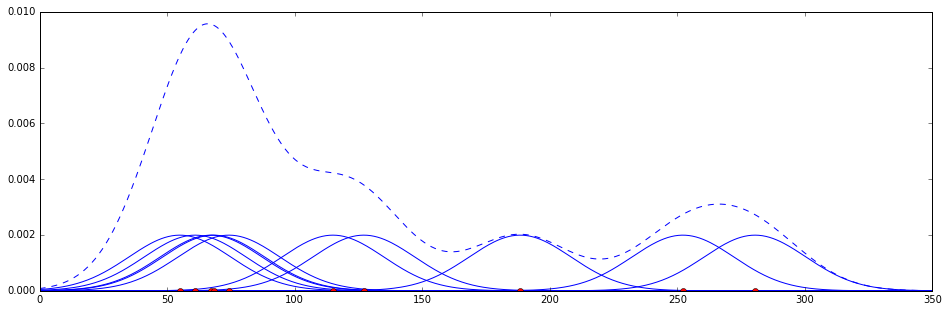

In [12]:
# Code showing how KDE works

##########################################
plt.rcParams["figure.figsize"] = (16,5)
##########################################

N = 10
dist = distributions.LognormalIncomeDistribution(mean = 100, Gini=0.3)
sample = dist.generate(N)

y = np.linspace(0, 350, 500)
kde_pdf = np.zeros_like(y)

for obs in sample:
    kernel = scipy.stats.norm(obs, 20)
    plt.plot(y, kernel.pdf(y)/N, 'b')
    kde_pdf = kde_pdf + kernel.pdf(y)/N

plt.plot(y, kde_pdf, 'b--')
plt.plot(sample, np.zeros_like(sample), 'ro')

Based, as it is, on sample (unit record) data, it is not obvious how kernel density estimation should be adapted for use with grouped data. Despite this, one strand of the income distribution literature does this, particularly the papers of Sala-i-Martin (e.g. [QJE 2006](https://academic.oup.com/qje/article-lookup/doi/10.1162/qjec.2006.121.2.351)). The exactly method is unclear (synthetic observations would need to be generated) and some of the justifications seems spurious, and indeed in more recent work ([NBER 2009](http://www.nber.org/papers/w15433)) Sala-i-Martin appears to prefer parametric fits. 

We do not attempt to follow this approach.

### Splines

Splines are piecewise polynomial functions in which continuity, and continuity of some derivatives, is enforced. They are widely used in engineering contexts as a general method of approximating smooth functions. They can be fit quickly by linear algebraic methods, and standard spline methods are widely implemented in numerical methods libraries. Conveniently, since splines are represented as segments of polynomials, they are closed under differentiation and integration. Unfortunately, they are not closed under inversion, so numerical methods are still required to move between the quantile function $Q(p)$ and the c.d.f $F(y)$ or p.d.f $f(y)$.

#### Linear and Cubic

Linear splines (splines of degree 1) are simply piecewise linear functions. At the end of Chapter 2, we outlined the reasons that fitting these to Lorenz curves is undesirable.

Cubic splines (splines of degree 3) are the most common in engineering applications. These provide a smooth Lorenz curve and a smooth, convincing distriution c.d.f. However, the p.d.f will be of degree 1 (piecewise linear), with sharp points and kinks.

See examples of cubic spline fits, below both without (top row) and with (bottom row) smoothing. Note that smoothing has little effect on the p.d.f (because it is acting at a higher level of integration) and, in particular, does not make the curves smooth in a geometric sense.

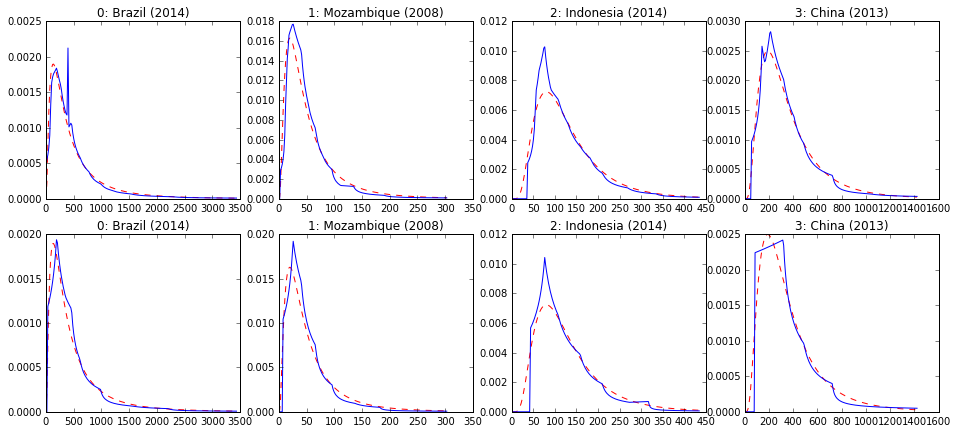

In [13]:
# Code to fit cubic spline Lorenz curves and plot the density for each example

##########################################
plt.rcParams["figure.figsize"] = (16,7)
fig, axs = plt.subplots(2, 4)
##########################################

for i, (survey, ax, refdist) in enumerate(zip(demos, axs.transpose(), refdists)):
    dist_nosmooth = distributions.SplineLorenzIncomeDistribution(
        survey.mean_ppp_month,
        survey.lorenz_points_p,
        survey.lorenz_points_L,
        k = 3
    )
    dist_smooth = distributions.SplineLorenzIncomeDistribution(
        survey.mean_ppp_month,
        survey.lorenz_points_p,
        survey.lorenz_points_L,
        k = 3,
        s = 2
    )
    y = np.linspace(0, refdist.quantile(0.99), 200)
    ax[0].plot(y, refdist.pdf(y), "r--")
    ax[0].plot(y, dist_nosmooth.pdf(y))
    ax[0].set_title("{}: {} ({})".format(i, survey.country, survey.year))

    ax[1].plot(y, refdist.pdf(y), "r--")
    ax[1].plot(y, dist_smooth.pdf(y))
    ax[1].set_title("{}: {} ({})".format(i, survey.country, survey.year))

Although cubic splines are not well suited to this problem, as the first nonparametric method we've applied to the example distributions, we should pause briefly to examine the differences between these fits and the lognormal fits, which is again shown as a reference:

- For Brazil and Mozambique, the modal value appears to be somewhat higher (further right) than in the lognormal fit.
- For Brazil, there appears to be a potential second mode in the distribution. Although this diminishes with smoothing, the feature remains. (Comparison of multiple years of data, not shown here, suggests this is, in fact, a real feature of the income distribution, and not an artefact.)
- For Indonesia, the distribution seems to be substantically 'peakier' than the lognormal approximation would suggest.

We should not overstate these differences: they are probably not important for the calculation of most important statistics. However, in keeping with the project objective of showing distributional detail, they are interesting for visualization purposes, so our aim is to retain them rather than over-smooth them away.

#### Higher-order

Since the p.d.f. relies on twice differentiating the Lorenz cuve, it stands to reason that if we require a smooth curve for the p.d.f (i.e. a spline of order 2, where the spline nodes share both location and slope), we should use a spline of order 4 or above. Indeed this produces more attractive p.d.f.s than the cubic splines, as demonstrated below (again unsmoothed - top row, and smoothed - bottom row).

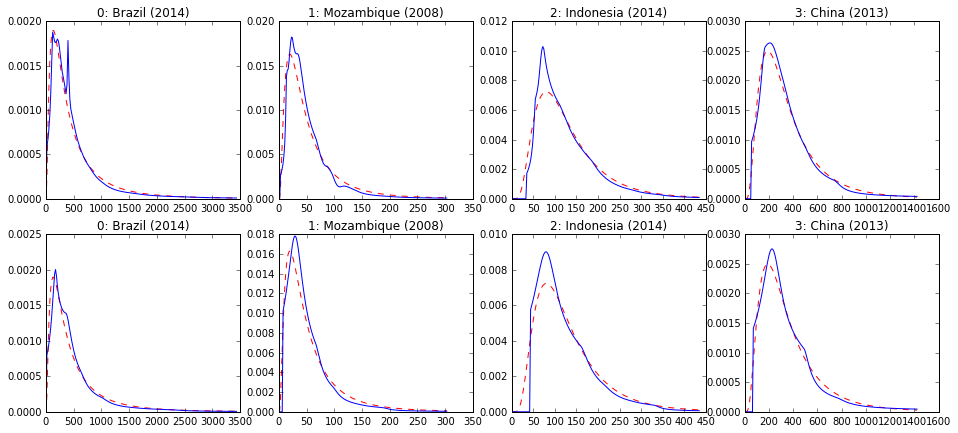

In [14]:
# Code to fit quartic spline Lorenz curves and plot the density for each example

##########################################
plt.rcParams["figure.figsize"] = (16,7)
fig, axs = plt.subplots(2, 4)
##########################################

for i, (survey, ax, refdist) in enumerate(zip(demos, axs.transpose(), refdists)):
    dist_nosmooth = distributions.SplineLorenzIncomeDistribution(
        survey.mean_ppp_month,
        survey.lorenz_points_p,
        survey.lorenz_points_L,
        k = 4
    )
    dist_smooth = distributions.SplineLorenzIncomeDistribution(
        survey.mean_ppp_month,
        survey.lorenz_points_p,
        survey.lorenz_points_L,
        k = 4,
        s = 2
    )
    y = np.linspace(0, refdist.quantile(0.99), 200)
    ax[0].plot(y, refdist.pdf(y), "r--")
    ax[0].plot(y, dist_nosmooth.pdf(y))
    ax[0].set_title("{}: {} ({})".format(i, survey.country, survey.year))

    ax[1].plot(y, refdist.pdf(y), "r--")
    ax[1].plot(y, dist_smooth.pdf(y))
    ax[1].set_title("{}: {} ({})".format(i, survey.country, survey.year))

A number of important features are visible from this example. First, the smoothness property is visible in both rows. Second, the use of smoothing makes a noticeable difference this time, in eliminating sampling noise. Third, the distributions may have a non-zero lower bound (like the general quadratic parametric fit, but unlike the lognormal parametric fit we are using as a reference) -- moveover, this lower bound tends to increase as a side effect of smoothing.

#### Constrained

One major issue with using splines to model Lorenz curves is that splines are not, in general, constrained to obey the properties of Lorenz curves (i.e. end point values, non-decreasing monotonicity, convexity). Often this is not important, as these constraints will not be binding, and an unconstrained spline will have these properties anyway. But this is not always true.

Many approaches are discussed in the literature for constraining cubic splines (e.g. [PCHIP](https://www.mathworks.com/help/matlab/ref/pchip.html)). Such methods are much rarer for higher-order splines, and none are available in standard libraries.

One method that looks promising was recently described by Zhang, Wu and Li ([2015](http://www.emeraldinsight.com/doi/full/10.1108/S0731-905320160000036028), [working paper](http://agecon2.tamu.edu/people/faculty/zhang-yvette/Publications/lorenz.pdf)). Following Ramsay (1998), the authors use a transformation of a spline that ensures the final output must be convex and increasing. If the spline itself is given by $m(t; \theta)$, with $z$ the parameters, then this approach instead fits the curve:

$$
s(u; \theta) = \int_0^u \exp \left( \int_0^s m^2(t; \theta) \, dt \right) \, ds
$$

The square of $m$ must be non-negative so it's integral (and the exponential of its integral) must be non-decreasing, so the integral of that, $s$, must be (at least weakly) convex.

Some efficiency gain is given as the inner integral can be solved analytically, however the outer integral still requires a numerical solution, so solving for the parameters (which requires iteration) is slow compared with an unconstrained spline. In our case, we found it too slow.

### Semi-parametric

We conclude this review with two methods with combine aspects of parametric estimation with non-parametric estimation. First is the method actually used, which we call _parametric-Lorenz-transformed spline_ fitting. The second is a recently published method used by the WID project, which shares some similarities (albeit applicable to a slightly different context).

#### Lorenz-transformed spline

This method is designed to address some of the issues with straightforward high-order spline fitting on the Lorenz curve. The key idea is that the overall shape of the Lorenz curve can be represented using a parametric distribution, while the deviations from that parametric form can be captured using a spline.

The steps we perform are as follows. Given the Lorenz points $\{p_i, L_i\}$

1. Calculate the Gini index and using that and the known mean, fit a lognormal distribution with Lorenz curve $L_{lognormal}$

2. Transform the points {L_i} using the inverse Lorenz curve, $p^*_i = L_{lognormal}^{-1}(L_i)$

3. Fit the curve $\{ p_i, p^*_i \}$ using a smoothed high-order spline. If original Lorenz points came exactly from a lognormal distribution, then this curve should be a 45 degree line. More realistically, when the distribution is close to lognormal in shape, there will be minor deviations from a 45 degree line, which the spline will fit.

One major advantage of this is that in the tails, the (exponential) lognormal Lorenz curve will tend to dominate the (polynomial) spline, so the tails will be effectively determined by the parametric choice rather than the spline. The resulting distribution will, for instance have support on $[0, \infty)$, which is convenient for manipulation.

Additionally, the lorenz curve of the lognormal is composed of the $\Phi$ and $\Phi^{-1}$ functions, which are available in efficient implementations in most stats/probability libraries. Further, the first derivative of the lognormal Lorenz-transformed spline can be calculated analytically, which improves computation time for $Q(p)$ (numerical inversion is still required for $F(y)$).

(Of course, the same technique could, in principle, be applied to a different parametric Lorenz curve).

For our example distributions, the method produces the following p.d.f.s:

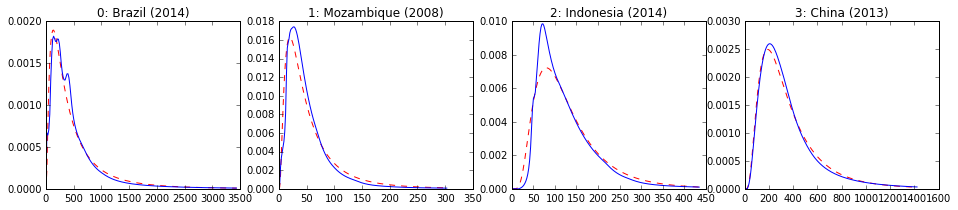

In [15]:
# Code to fit parametric-Lorenz-transformed spline curves and plot the density for each example

##########################################
plt.rcParams["figure.figsize"] = (16,3)
fig, axs = plt.subplots(1, 4)
##########################################

for i, (survey, ax, refdist) in enumerate(zip(demos, axs, refdists)):
    dist_smooth = distributions.TransformedSplineIncomeDistribution(
        survey.mean_ppp_month,
        survey.lorenz_points_p,
        survey.lorenz_points_L,
        distributions.LognormalIncomeDistribution,
        s = 1
    )
    y = np.linspace(0, refdist.quantile(0.99), 200)

    ax.plot(y, refdist.pdf(y), "r--")
    ax.plot(y, dist_smooth.pdf(y))
    ax.set_title("{}: {} ({})".format(i, survey.country, survey.year))

Note that, in common with the parametric lognormal fits, these densities descend smoothly to zero, and asymptote to infinity. At the same time, they preserve some of the detailed features of the distributions found in the spline fits, above (for example, the bulge in the Brazil density, and the peak of the Indonesia distribution).

> Above we have used a fixed smoothing parameter. In practice, for the present visualisation, we select the smoothing parameter based on some heuristics: with aim for the minimum smoothing that eliminates spikes in the distribution and results in no more than X local maxima.

#### Postscript: generalized Pareto curves

During the course of this project, the WID project published [Blanchet, Fournier and Piketty (March 2017)](http://piketty.pse.ens.fr/files/BlanchetFournierPiketty2017WIDworld.pdf) (based largely on [Fournier's 2015 master's thesis](http://piketty.pse.ens.fr/files/Fournier2015.pdf)). This method of fitting grouped income data requires access to the group thresholds, which are not available in PovCalNet output, so we are unable to test it. It does, however, share conceptual similarities with our preferred Lorenz-transformed spline method, in particular the spline fitting of a transformation of the grouped data. For this reason we briefly outline it now.

The method takes its inspiration from the Pareto distribution, commonly used to model income distribution, which has the c.d.f

$$
F(y) = 1 - \left(\frac{y}{y_{min}}\right)^\alpha, \  y > y_{min}
$$

One property of this distribution is that the mean of incomes above any threshold, divided by the threshold, is constant. That is, for all $y$,

$$
\frac{E(Y|Y > y)}{y} = \frac{\alpha}{\alpha - 1} = b
$$

The authors generalize this property to non-Pareto distributions by first allowing $b(y)$ to vary in $y$, and then by reparameterising $b$ using $y = Q(p)$ to arrive at a function on $[0, 1]$, $b(p) = b(Q(p))$.

From grouped data with thresholds, one can then calculate - and plot - the sample analogue of this function, at the observed group thresholds. From there the authors use high-order spline interpolation to fit the entire function, which can then be used to reconstruct the density.

Although this method cannot be used to solve our problem, it could be compared with the Lorenz-transformed spline method (by simply discarding the threshold data), which would be a wortwhile exercise.